In [ ]:
!pip install beautifulsoup4 requests wordcloud matplotlib pandas
!pip install -qU transformers torch datasets gdcm pydicom pinecone-client
!pip install openai

## Data **preparation**



In [ ]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

In [ ]:
!unzip /content/nature_EM.zip

In [ ]:
# JSON file
import json
f = open('/content/nature_EM/exsclaim.json')

# Reading from file
data = json.loads(f.read())
len(data)

269

In [ ]:
filtered_data = {key: value for key, value in data.items() if value['full_caption']}
data = filtered_data
len(data)

269

In [ ]:
import numpy as np
import requests
from PIL import Image
import io

def process_from_url(image_url):
  response = requests.get(image_url)
  img = Image.open(io.BytesIO(response.content))
  return np.array(img)

def process_from_figures(figure_name):
  image_path = os.path.join('/content/nature_EM/figures', figure_name)
  # print(image_path)
  img = Image.open(image_path)
  return np.array(img)

def crop_from_geometry(geometry, image):
    """Returns an image cropped to include coordinates in geometry

    Args:
        geometry (list of dicts): Geometry JSON from exsclaim JSON.
            4 dicts, each have x and y coords for corners of bounding
            box. [Top left, bottom left, top right, bottom right]
        image (np.array): Numpy array representing an image to be cropped
    Returns:
        Cropped image according to geometry given as numpy array
    """
    x1, y1 = geometry[0]["x"], geometry[0]["y"]
    x2, y2 = geometry[3]["x"], geometry[3]["y"]
    return image[y1:y2, x1:x2]

def image_to_base64(img):
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode()

In [ ]:
captions = []
subfigures_url=[]
images_path = []
captions_summary = []
for key in data.keys():
  try:
    full_img = process_from_figures(data[key]["figure_name"])
  except:
    continue

  for i in range(len(data[key]["master_images"])):
    if data[key]["master_images"][i]["classification"] == "microscopy":

      geometry = data[key]["master_images"][i]["geometry"]
      #print(geometry)
      label = data[key]["master_images"][i]["subfigure_label"]["text"]
      caption =  data[key]["master_images"][i]["caption"] #["keywords"]#["caption"]
      caption_summary =  data[key]["master_images"][i]["keywords"]
      img_name = data[key]["figure_name"].rsplit('.', 1)[0] + "_" + label
      # print('img_name', img_name)
      # print(caption)
      subfigure = crop_from_geometry(geometry, full_img)
      # Image.fromarray(subfigure).show()
      # print(subfigure)
      try:
        subfigure = Image.fromarray(subfigure)
        subfigure.show()
        subfigure = subfigure.convert("RGB")
        file_path = f"image_folder/{img_name}.jpg"
        subfigure.save(file_path)
        subfigures_url.append(file_path)
        captions.append(caption)
        captions_summary.append(caption_summary)
      except:
        subfigures_url.append(0)
        captions.append(0)
        captions_summary.append(0)

In [ ]:
image_data_df = pd.DataFrame({
    'caption': captions,
    'caption_summary': captions_summary,
    'image': subfigures_url
})

image_data_df = image_data_df.loc[(image_data_df != 0).all(axis=1)]
image_data_df = image_data_df.loc[(image_data_df != None).all(axis=1)]
image_data_df = image_data_df[image_data_df['caption'].astype(bool)].reset_index()

In [ ]:
# Save the csv file with the location of the image, the full image caption and the caption summary
image_data_df.to_csv('nature_EM_MC.csv', index=None)

# CLIP

In [ ]:
# Read the csv file with the image and text data
image_data_df = pd.read_csv('nature_EM_MC.csv')

In [ ]:
!unzip /content/image_folder_nature_EM.zip
!mv content/image_folder .

In [ ]:
def get_model_info(model_ID, device):

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [ ]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

In [ ]:
def get_single_text_embedding(text):

  inputs = tokenizer(text, return_tensors = "pt").to(device)

  text_embeddings = model.get_text_features(**inputs)

  # convert the embeddings to numpy array
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

In [ ]:
def get_all_text_embeddings(df, text_col):

   df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)

   return df

In [ ]:
def get_single_image_embedding(my_image):
  # image = Image.open(my_image).convert("RGB")
  image = processor(
      text = None,
      images = my_image,
      return_tensors="pt"
  )["pixel_values"].to(device)

  embedding = model.get_image_features(image)

  # convert the embeddings to numpy array
  embedding_as_np = embedding.cpu().detach().numpy()

  return embedding_as_np

In [ ]:
def get_all_images_embedding(df, img_column):

  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)

  return df

In [ ]:
img_embeddings = []
text_embeddings = []

for i in range(image_data_df.shape[0]):
  try:
    image = Image.open(image_data_df.image.values[i]).convert("RGB")
    img_embeddings.append(get_single_image_embedding(image))

  except:
     img_embeddings.append(0)
  try:
    text_embeddings.append(get_single_text_embedding(image_data_df.caption_summary.values[i]))
  except:
     text_embeddings.append(0)

image_data_df["img_embeddings"] = img_embeddings
image_data_df["text_embeddings"] = text_embeddings

In [ ]:
image_data_df

,level_0,index,caption,caption_summary,image,img_embeddings,text_embeddings
0,0,1,DF TEM images (g=10-1-0; left),"['TEM images', 'material characterization', 'g...",image_folder/s41563-023-01595-0_fig3_a.jpg,"[[0.06948473, -0.36536372, 0.27484047, -0.2526...","[[0.005840171, 0.28504398, 0.09055625, 0.11685..."
1,1,2,Aberration-corrected ADF STEM images taken at ...,"['STEM images', 'edge pinning site', 'aberrati...",image_folder/s41563-023-01595-0_fig3_e.jpg,"[[0.15159929, -0.21024375, 0.3816597, -0.00390...","[[-0.28601715, -0.03800089, 0.12040049, 0.0287..."
2,2,3,Aberration-corrected ADF STEM images taken at ...,"['STEM images', 'bulk pinning site', 'aberrati...",image_folder/s41563-023-01595-0_fig3_f.jpg,"[[0.16991529, -0.2834663, 0.20650008, -0.20182...","[[-0.21461198, 0.021258444, 0.12097737, 0.1077..."
3,3,4,A CryoEM map of a thread cable at 13 Å resolut...,"['CryoEM', 'thread cable', '13 Å resolution']",image_folder/s41467-022-34652-4_fig2_a.jpg,"[[0.2481841, 0.070954174, -0.6424777, -0.45516...","[[-0.3559463, 0.33611608, 0.20462826, 0.002492..."
4,4,5,Graphene covering a region (Gr) of Alexa Fluor...,"['graphene', 'fluorescence microscopy', 'cell ...",image_folder/ncomms8384_fig1_b.jpg,"[[0.20242147, -0.68546414, 0.34504092, -0.1984...","[[-0.17452665, -0.19387802, -0.41022077, -0.12..."
...,...,...,...,...,...,...,...
380,380,425,Schematic drawings of the initial SEI nucleati...,"['SEI nucleation', 'cycle structure']",image_folder/s41467-021-23368-6_fig6_c.jpg,"[[0.13749911, -0.4143286, 0.08236567, -0.05852...","[[-0.07637293, -0.057029016, 0.41386628, 0.256..."
381,381,426,corresponding cryo-TEM image after ten cycles ...,"['cryo-TEM image', 'electrolyte', 'cycles']",image_folder/s41467-021-23368-6_fig6_f.jpg,"[[-0.043107297, -0.52908826, -0.031140551, -0....","[[-0.29352462, 0.17013352, 0.36676425, 0.05594..."
382,382,427,Fluorescence microscopy image (600 × 600 μm2) ...,"['PVC', 'TPE-DTAB', 'MMT']",image_folder/ncomms11811_fig4_b.jpg,"[[0.3323599, -0.40636384, 0.275132, 0.05097019...","[[0.014176786, -0.01686395, -0.042407975, -0.1..."
383,383,428,Cross-sectional TEM micrograph of PVC/TPE-DTAB...,"['PVC', 'TPE-DTAB', 'MMT']",image_folder/ncomms11811_fig4_a.jpg,"[[0.09346691, -0.23584065, 0.23679967, -0.2758...","[[0.014176786, -0.01686395, -0.042407975, -0.1..."


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import textwrap
from sklearn.metrics.pairwise import cosine_similarity

def plot_images(images):

  for image in images:
    plt.imshow(image)
    plt.show()



def plot_images_by_side(top_images):
    index_values = list(top_images.index.values)
    list_images = [top_images.iloc[idx].image for idx in index_values]
    list_captions = [top_images.iloc[idx].caption_summary for idx in index_values]
    similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]

    n_row = n_col = 2

    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
        img1 = mpimg.imread(img)
        ax.imshow(img1)
        ax.axis('off')
        sim_score = 100 * float("{:.2f}".format(sim_score))
        wrapped_caption = textwrap.fill(f"Caption keywords: {caption}\nSimilarity Score: {sim_score}%", width=50)
        ax.text(0.5, 0.1, wrapped_caption, ha='center', va='center', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
    plt.show()


In [ ]:
def get_top_N_images(query, data, top_K=4, search_criterion="text"):

    """
    Retrieve top_K (5 is default value) articles similar to the query
    """
    # Text to image Search
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query)

    # Image to image Search
    else:
      query_vect = get_single_image_embedding(query)

    # Relevant columns
    revevant_cols = ["caption_summary", "image", "cos_sim"]

    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))
    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])

    """
    Sort Cosine Similarity Column in Descending Order
    Here we start at 1 to remove similarity with itself because it is always 1
    """
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False)[1:top_K+1]

    return most_similar_articles[revevant_cols].reset_index()

In [ ]:
query_caption = 'graphene'

In [ ]:
top_images = get_top_N_images(query_caption, image_data_df)
print("Query: {}".format(query_caption))
top_images

Query: graphene


,index,caption_summary,image,cos_sim
0,178,"['graphene', 'potential', 'TEM imaging']",image_folder/nmat2941_fig1_b.jpg,0.309523
1,9,"['graphene', 'cells', 'sample']",image_folder/ncomms8384_fig2_c.jpg,0.304222
2,175,"['Projected potential', 'all-electron DFT calc...",image_folder/nmat2941_fig1_e.jpg,0.293753
3,5,"['Graphene', 'cells', 'characterization']",image_folder/ncomms8384_fig1_e.jpg,0.290810


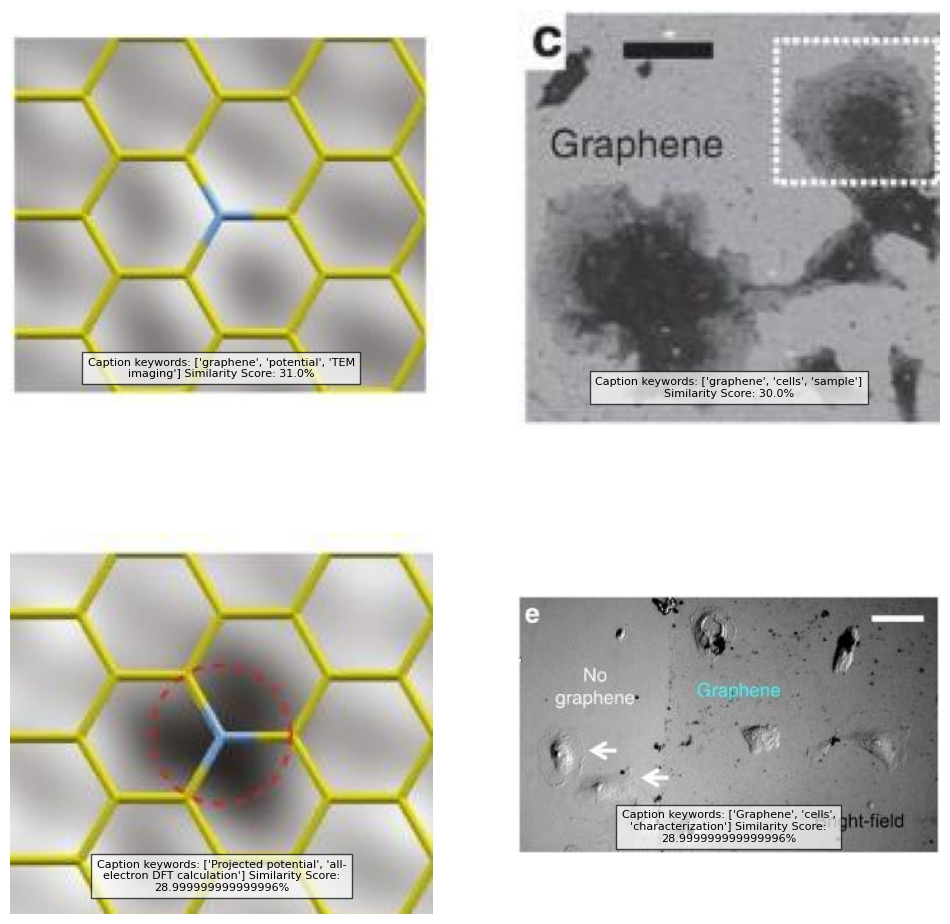

In [ ]:
plot_images_by_side(top_images)